# This is an example notebook for running the CSU_Radartools hydrometeor identificaiton

## Brenda Dolan, October 2020

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import matplotlib.colors as colors

from skewPy import SkewT
from pathlib import Path

from CSU_RadarTools.csu_radartools import csu_fhc

import pyart

%matplotlib inline




## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



/home/bdolan/anaconda3/envs/py37i/lib/python3.6/site-packages/pyart/graph/cm.py:104: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'red' in spec:
/home/bdolan/anaconda3/envs/py37i/lib/python3.6/site-packages/pyart/graph/cm_colorblind.py:32: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'red' in spec:


# These are some helper functions

In [2]:
## setup the summre colors.
hid_colors =  ['White','LightBlue','MediumBlue','Darkorange','LightPink','Cyan','DarkGray',\
            'Lime','Yellow','Red','Fuchsia']
cmaphid = colors.ListedColormap(hid_colors)


##Setup the winter colors.

hid_colors_winter = ['White','Orange', 'Purple', 'Fuchsia', 'Pink', 'Cyan',
              'LightBlue', 'Blue']#, 'Lime', 'Yellow', 'Red', 'Fuchsia']
cmaphidwinter = colors.ListedColormap(hid_colors_winter)




def interpolate_sounding_to_radar(sounding, radar):
    """Takes sounding data and interpolates it to every radar gate."""
    radar_z = get_z_from_radar(radar)
    radar_T = None
    snd_T, snd_z = check_sounding_for_montonic(sounding)
    shape = np.shape(radar_z)
    rad_z1d = radar_z.ravel()
    rad_T1d = np.interp(rad_z1d, snd_z, snd_T)
    return np.reshape(rad_T1d, shape), radar_z

def check_sounding_for_montonic(sounding):
    """
    So the sounding interpolation doesn't fail, force the sounding to behave
    monotonically so that z always increases. This eliminates data from
    descending balloons.
    """
    snd_T = sounding['temp']  # In old SkewT, was sounding.data
    snd_z = sounding['hght']  # In old SkewT, was sounding.data
    dummy_z = []
    dummy_T = []
    #print(snd_T.mask)
    if not snd_T.mask.all(): #May cause issue for specific soundings
        dummy_z.append(snd_z[0])
        dummy_T.append(snd_T[0])
        for i, height in enumerate(snd_z):
            if i > 0:
                if snd_z[i] > snd_z[i-1] and not snd_T.mask[i]:
                    if np.isfinite(snd_z[i]) and np.isfinite(snd_T[i]):
                        #print(snd_T[i])
                        dummy_z.append(snd_z[i])
                        dummy_T.append(snd_T[i])
        snd_z = np.array(dummy_z)
        snd_T = np.array(dummy_T)
    else:
        print('uh-oh. sounding problem')
    return snd_T, snd_z

def get_z_from_radar(radar):
    """Input radar object, return z from radar (km, 2D)"""
    azimuth_1D = radar.azimuth['data']
    elevation_1D = radar.elevation['data']
    srange_1D = radar.range['data']
    sr_2d, az_2d = np.meshgrid(srange_1D, azimuth_1D)
    el_2d = np.meshgrid(srange_1D, elevation_1D)[1]
    xx, yy, zz = radar_coords_to_cart(sr_2d/1000.0, az_2d, el_2d)
    #print(np.shape(zz), np.shape(radar.altitude['data']))
    try:
        return zz + radar.altitude['data'][0]
    except:
        return zz + radar.altitude['data']
    
def radar_coords_to_cart(rng, az, ele, debug=False):
    """
    TJL - taken from old Py-ART version
    Calculate Cartesian coordinate from radar coordinates
    Parameters
    ----------
    rng : array
        Distances to the center of the radar gates (bins) in kilometers.
    az : array
        Azimuth angle of the radar in degrees.
    ele : array
        Elevation angle of the radar in degrees.
    Returns
    -------
    x, y, z : array
        Cartesian coordinates in meters from the radar.
    Notes
    -----
    The calculation for Cartesian coordinate is adapted from equations
    2.28(b) and 2.28(c) of Doviak and Zrnic [1]_ assuming a
    standard atmosphere (4/3 Earth's radius model).
    .. math::
        z = \\sqrt{r^2+R^2+r*R*sin(\\theta_e)} - R
        s = R * arcsin(\\frac{r*cos(\\theta_e)}{R+z})
        x = s * sin(\\theta_a)
        y = s * cos(\\theta_a)
    Where r is the distance from the radar to the center of the gate,
    :math:\\theta_a is the azimuth angle, :math:\\theta_e is the
    elevation angle, s is the arc length, and R is the effective radius
    of the earth, taken to be 4/3 the mean radius of earth (6371 km).
    References
    ----------
    .. [1] Doviak and Zrnic, Doppler Radar and Weather Observations, Second
        Edition, 1993, p. 21.
    """
    theta_e = ele * np.pi / 180.0  # elevation angle in radians.
    theta_a = az * np.pi / 180.0  # azimuth angle in radians.
    R = 6371.0 * 1000.0 * 4.0 / 3.0  # effective radius of earth in meters.
    r = rng * 1000.0  # distances to gates in meters.

    z = (r ** 2 + R ** 2 + 2.0 * r * R * np.sin(theta_e)) ** 0.5 - R
    s = R * np.arcsin(r * np.cos(theta_e) / (R + z))  # arc length in m.
    x = s * np.sin(theta_a)
    y = s * np.cos(theta_a)
    return x, y, z

def add_field_to_radar_object(field, radar, field_name='FH', units='unitless', 
                              long_name='Hydrometeor ID', standard_name='Hydrometeor ID',
                              dz_field='CZ'):
    """
    Adds a newly created field to the Py-ART radar object. If reflectivity is a masked array,
    make the new field masked the same as reflectivity.
    """
    fill_value = -32768
    masked_field = np.ma.asanyarray(field)
    masked_field.mask = masked_field == fill_value
    if hasattr(radar.fields[dz_field]['data'], 'mask'):
        setattr(masked_field, 'mask', 
                np.logical_or(masked_field.mask, radar.fields[dz_field]['data'].mask))
        fill_value = radar.fields[dz_field]['_FillValue']
    field_dict = {'data': masked_field,
                  'units': units,
                  'long_name': long_name,
                  'standard_name': standard_name,
                  '_FillValue': fill_value}
    radar.add_field(field_name, field_dict, replace_existing=True)
    return radar

def adjust_fhc_colorbar_for_pyart(cb,type='summer'):
    if type == 'summer':
        cb.set_ticks(np.arange(1.4, 10, 0.9))
        cb.ax.set_yticklabels(['Drizzle', 'Rain', 'Ice Crystals', 'Aggregates',
                               'Wet Snow', 'Vertical Ice', 'LD Graupel',
                               'HD Graupel', 'Hail', 'Big Drops'])
    if type == 'winter':
        cb.set_ticks(np.arange(1.4, 7, 0.9))
        cb.ax.set_yticklabels(['IC','Plates', 'Dendrites', 'Aggregates', 'Wet Snow',
                           'LightRain', 'Rain'])

    cb.ax.set_ylabel('')
    cb.ax.tick_params(length=0)

    return cb

def three_panel_plot(radar, sweep=0, var1='reflectivity', vmin1=0, vmax1=65,
                   cmap1='RdYlBu_r', units1='dBZ', var2='VEL',
                   vmin2=-20, vmax2=20, cmap2='RdYlBu_r', units2='m/s',
                   var3 = 'HCA',vmin3=0,vmax3=8,cmap3='Reds',units3='',return_flag=False,norm3=None,
                   xlim=[-150,150], ylim=[-150,150]):
    display = pyart.graph.RadarDisplay(radar)
    fig = plt.figure(figsize=(13,8))
    ax1 = fig.add_subplot(311)
    if radar.scan_type == 'rhi':
        display.plot_rhi(var1, sweep=sweep, vmin=vmin1, vmax=vmax1, cmap=cmap1,
                         colorbar_label=units1, mask_outside=True)
        display.set_limits(xlim=xlim, ylim=ylim)
        ax2 = fig.add_subplot(312)
        display.plot_rhi(var2, sweep=sweep, vmin=vmin2, vmax=vmax2, cmap=cmap2,
                         colorbar_label=units2, mask_outside=True)
        display.set_limits(xlim=xlim, ylim=ylim)

        ax3 = fig.add_subplot(313)
        if norm3 is not None:
            display.plot_rhi(var3, sweep=sweep, vmin=vmin3, vmax=vmax3, cmap=cmap3,
                             colorbar_label=units3, mask_outside=True,norm=norm3)
        else:
            display.plot_rhi(var3, sweep=sweep, vmin=vmin3, vmax=vmax3, cmap=cmap3,
                             colorbar_label=units3, mask_outside=True)

            
        display.set_limits(xlim=xlim, ylim=ylim)

        
    
    else:
        display.plot_ppi(var1, sweep=sweep, vmin=vmin1, vmax=vmax1, cmap=cmap1,
                         colorbar_label=units1, mask_outside=True)
        display.set_limits(xlim=xlim, ylim=ylim)
        ax2 = fig.add_subplot(212)
        display.plot_ppi(var2, sweep=sweep, vmin=vmin2, vmax=vmax2, cmap=cmap2,
                         colorbar_label=units2, mask_outside=True)
        display.set_limits(xlim=xlim, ylim=ylim)
    if return_flag:
        return fig, ax1, ax2, ax3,display


# RHI

## First we will start by reading in an RHI from the NPOL radar during OLYMPEX.

In [3]:
radar = pyart.io.read('/andes1/olympex/OLYMPEX_NPOL/11/1117/rhi_b/NPOL1_2015_1117_181215_rhi.uf')

In [4]:
radar.fields.keys()

dict_keys(['corrected_reflectivity', 'corrected_differential_reflectivity', 'cross_correlation_ratio', 'differential_phase', 'specific_differential_phase', 'normalized_coherent_power', 'spectrum_width', 'velocity'])

In [5]:
###all of the HIDs will be improved by including temperature data. This is not required, but
###definitely helps. The temperature just has to be the same shape / size as the radar data.

#I am going to read in a sounding and interpolate it to the radar gates. You could also use
#reanalysis data, or a assumed temperature profile.

##The HCA "winter HID" does better if there is an expected melting layer to determine how far
##the polarimetrically identified ML deviates from the assumed profile.

sounding = SkewT.Sounding('/andes1/olympex/OLYMPEX_NPOL/QUIL_SOUNDINGS/20151117_12z_QUIL.txt')
wh0 = np.where(np.isclose(np.abs(sounding['temp']),0.0,atol=1.0))
expected_ML = np.array(sounding['hght'])[wh0[0]][0]/1000.

####Interpolate the sounding to the radar heights
radar_T, radar_z = interpolate_sounding_to_radar(sounding, radar)



# HCA "winter"
Thompson, E. J., Rutledge, S. A., Dolan, B., Chandrasekar, V., & Cheong, B. L. (2014). A dual-polarization radar hydrometeor classification algorithm for winter precipitation. Journal of Atmospheric and Oceanic Technology, 31(7), 1457-1481.

#### Cateories:
#### 0  = Unclassified
#### 1  = Ice Crystals
#### 2  = Plates
#### 3  = Dendrites
#### 4  = Aggregates
#### 5  = Wet Snow
#### 6  = Frozen precip
#### 7  = Rain


In [6]:
##The winter algorithm relies heavliy on Zdr, Kdp, and Rhohv so including these is critical.
##The radar heights should be in km, as should the expected melting layer.
#We also need the radar scan type (ppi or rhi) to determien the best way to find the bright band.

#setup some things needed by the HCA. You can also pass these directly in but I've listed them
#out here for clarity.
rband = 'S'                 #Radar band -- critical for selecting the approproate beta functions
scan_type = radar.scan_type #rhi or ppi, determines how the melting layer identification will be done
use_temp = True             #use the temperature
verbose = False             #Do not print out verbose 
minRH = 0.5                 #Since RH is so important for ML detection, there is a minimum rho 
                            #threshold for good data
rheights = radar_z/1000.    #radar heights should be in km.

return_scores = False      #For certain things, like testing the relative scoring for 2nd place
                            #categories, you might want to return the whole score matrix, including
                            #for each of the intermediate fuzzy logic steps such as the melting level
                            #scoring. Otherwise it will just return the highest ranking category.

#If signal to noise ratio is available, the results of the classification 
#will be improved (be sure to also test the SNR threshold). If it is not, you can add it with pyart if you are working in polar coordiantes:
# sn =pyart.retrieve.simple_moment_calculations.calculate_snr_from_reflectivity(radar,refl_field='corrected_reflectivity',toa=15000.0)
# sndat= sn['data'][:]
#add SNR to the radar structure
#radar = add_field_to_radar_object(sndat, radar,field_name='SN',dz_field='corrected_reflectivity')
#sndat =np.ma.masked_array(sndat)

#However, for this example, I'm choosing not to use it.

#Radar variables. These should be just the data (not an object), and masked arrays
dz = np.ma.masked_array(radar.fields['corrected_reflectivity']['data'])
dr = np.ma.masked_array(radar.fields['corrected_differential_reflectivity']['data'])
kd = np.ma.masked_array(radar.fields['specific_differential_phase']['data'])
rh = np.ma.masked_array(radar.fields['cross_correlation_ratio']['data'])


hcawinter = csu_fhc.run_winter(dz=dz,zdr=dr,kdp=kd,rho=rh,
                              expected_ML=expected_ML,sn=None,T=radar_T,heights=rheights,
                              scan_type = scan_type,verbose=verbose,use_temp = use_temp,
                              band=rband, return_scores=return_scores)


###Now add this back to the radar object.

radar = add_field_to_radar_object(hcawinter, radar,field_name='HCA',dz_field='corrected_reflectivity')




Melting level height:2.42
RADAR MELTING IS: 2.419


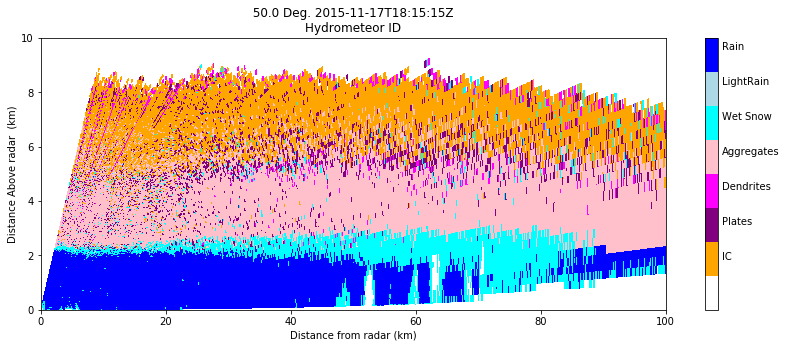

In [7]:
###Let's see what we got.
fig, ax = plt.subplots(1,1,figsize=(14,5))
display = pyart.graph.RadarDisplay(radar)
display.plot('HCA',sweep=10,vmin=0,vmax=7,cmap=cmaphidwinter)
display.cbs[0] = adjust_fhc_colorbar_for_pyart(display.cbs[0],'winter')
display.set_limits([0,100],[0,10])


# HID "summer"
Dolan, B., S. A. Rutledge, S. Lim, V. Chandrasekar, and M. Thurai, 2013: A robust C-band hydrometeor identification algorithm and application to a long term polarimetric radar data set. J. Appl. Meteor., 52, 2162-2186.

Dolan, B., and S. A. Rutledge, 2009: A theory-based hydrometeor identification algorithm for X-band polarimetric radars. J. Oceanic Atmos. Technol., 46, 1196-1213, 10.1175/2009JTECHA1208.1.


#### Cateories:
#### 0  = Unclassified
#### 1  = Drizzle
#### 2  = Rain
#### 3  = Dry snow
#### 4  = Aggregates
#### 5  = Wet Snow
#### 6  = Vertical Ice
#### 7  = Low-density graupel
#### 8  = High-density graupel
#### 9 = Hail
#### 10 = Big drops / melting hail



In [8]:
##Let's see how the winter compares with the summer.

## We will start by using the temperature beta funcitons, and the hybrid scoring method.

hid = csu_fhc.csu_fhc_summer(dz=dz, zdr=dr, rho=rh, kdp=kd, use_temp=True,T=radar_T, band=rband,
                                verbose=False,use_trap=False,method='hybrid')#,fdir ='/home/bdolan/python/CSU_RadarTools/csu_radartools/beta_function_parameters/')


###Now add this back to the radar object.

radar = add_field_to_radar_object(hid, radar,field_name='HID',dz_field='corrected_reflectivity')


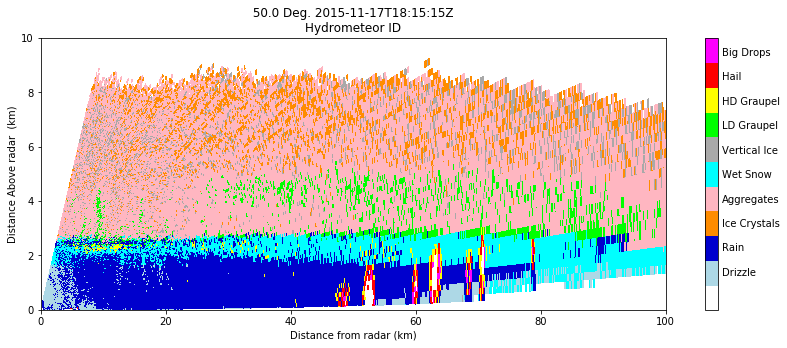

In [9]:
###Let's see what we got.
fig, ax = plt.subplots(1,1,figsize=(14,5))
display = pyart.graph.RadarDisplay(radar)
display.plot('HID',sweep=10,vmin=0,vmax=10,cmap=cmaphid)
display.cbs[0] = adjust_fhc_colorbar_for_pyart(display.cbs[0],'summer')
display.set_limits([0,100],[0,10])



In [10]:
###Now what happens if we use the trapazoidal functions and the 'linear' scoring?
hidT = csu_fhc.csu_fhc_summer(dz=dz, zdr=dr, rho=rh, kdp=kd, use_temp=True,T=radar_T, band=rband,
                                verbose=False,use_trap=True,method='linear')#,fdir ='/home/bdolan/python/CSU_RadarTools/csu_radartools/beta_function_parameters/')


###Now add this back to the radar object.

radar = add_field_to_radar_object(hidT, radar,field_name='HIDT',dz_field='corrected_reflectivity')



0.5


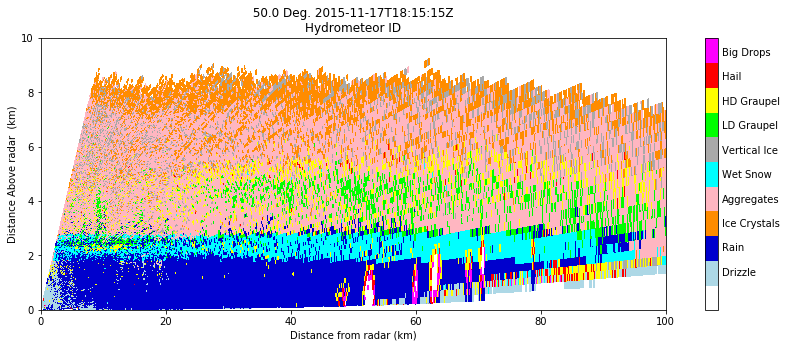

In [11]:
###Let's see what we got.
fig, ax = plt.subplots(1,1,figsize=(14,5))
display = pyart.graph.RadarDisplay(radar)
display.plot('HIDT',sweep=10,vmin=0,vmax=10,cmap=cmaphid)
display.cbs[0] = adjust_fhc_colorbar_for_pyart(display.cbs[0],'summer')
display.set_limits([0,100],[0,10])




# Try a PPI

### PPIs work slightly differently because of the bright band detection algorithm.

In [12]:
radar = pyart.io.read('/andes1/olympex/OLYMPEX_NPOL/11/1117/ppi/NPOL1_2015_1117_001839.uf')

In [13]:
###all of the HIDs will be improved by including temperature data. This is not required, but
###definitely helps. The temperature just has to be the same shape / size as the radar data.

#I am going to read in a sounding and interpolate it to the radar gates. You could also use
#reanalysis data, or a assumed temperature profile.

##The HCA "winter HID" does better if there is an expected melting layer to determine how far
##the polarimetrically identified ML deviates from the assumed profile.

sounding = SkewT.Sounding('/andes1/olympex/OLYMPEX_NPOL/QUIL_SOUNDINGS/20151117_12z_QUIL.txt')
wh0 = np.where(np.isclose(np.abs(sounding['temp']),0.0,atol=1.0))
expected_ML = np.array(sounding['hght'])[wh0[0]][0]/1000.

####Interpolate the sounding to the radar heights
radar_T, radar_z = interpolate_sounding_to_radar(sounding, radar)




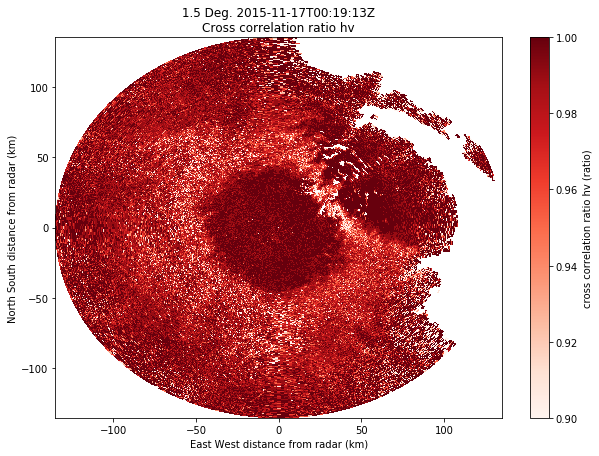

In [14]:
#I selected a messy case with a non-concentric bright band to look at the performance for PPI.
#Check out this rho_hv signature.

fig, ax = plt.subplots(1,1,figsize=(10,7))
display = pyart.graph.RadarDisplay(radar)
display.plot('cross_correlation_ratio',sweep=1,vmin=0.9,vmax=1,cmap='Reds')




In [15]:
##The winter algorithm relies heavliy on Zdr, Kdp, and Rhohv so including these is critical.
##The radar heights should be in km, as should the expected melting layer.
#We also need the radar scan type (ppi or rhi) to determien the best way to find the bright band.

#setup some things needed by the HCA. You can also pass these directly in but I've listed them
#out here for clarity.
rband = 'S'                 #Radar band -- critical for selecting the approproate beta functions
scan_type = radar.scan_type #rhi or ppi, determines how the melting layer identification will be done
use_temp = True             #use the temperature
verbose = False             #Do not print out verbose 
minRH = 0.5                 #Since RH is so important for ML detection, there is a minimum rho 
                            #threshold for good data
rheights = radar_z/1000.    #radar heights should be in km.


return_scores = False      #For certain things, like testing the relative scoring for 2nd place
                            #categories, you might want to return the whole score matrix, including
                            #for each of the intermediate fuzzy logic steps such as the melting level
                            #scoring. Otherwise it will just return the highest ranking category.

#If signal to noise ratio is available, the results of the classification 
#can be improved (be sure to also test the SNR threshold). If it is not, you can add it with pyart if you are working in polar coordiantes:

sn =pyart.retrieve.simple_moment_calculations.calculate_snr_from_reflectivity(radar,refl_field='corrected_reflectivity',toa=15000.0)
sndat= sn['data'][:]
#add SNR to the radar structure
radar = add_field_to_radar_object(sndat, radar,field_name='SN',dz_field='corrected_reflectivity')
sndat =np.ma.masked_array(sndat)

###If you use SNR, select an appropriate threshold for your data.
snthresh = -30


###Azimuths are important for the PPI data for the bright band detection.
azimuths = radar.azimuth['data']

##The melting layer algorithm for PPIs takes different sectors. The easiest is to do 10º sectors, and pass nsect=36 (also
# the default). But you could change to any multiple of 360 (or the number of azimuths you have).
nsect = 36

#Radar variables. These should be just the data (not an object), and masked arrays
dz = np.ma.masked_array(radar.fields['corrected_reflectivity']['data'])
dr = np.ma.masked_array(radar.fields['corrected_differential_reflectivity']['data'])
kd = np.ma.masked_array(radar.fields['specific_differential_phase']['data'])
rh = np.ma.masked_array(radar.fields['cross_correlation_ratio']['data'])


hcawinter = csu_fhc.run_winter(dz=dz,zdr=dr,kdp=kd,rho=rh,azimuths=azimuths,sn_thresh=snthresh,
                              expected_ML=expected_ML,sn=sndat,T=radar_T,heights=rheights,nsect=nsect,
                              scan_type = scan_type,verbose=verbose,use_temp = use_temp,
                              band=rband, return_scores=return_scores)


###Now add this back to the radar object.

radar = add_field_to_radar_object(hcawinter, radar,field_name='HCA',dz_field='corrected_reflectivity')





RADAR MELTING IS: 1.756114285332816


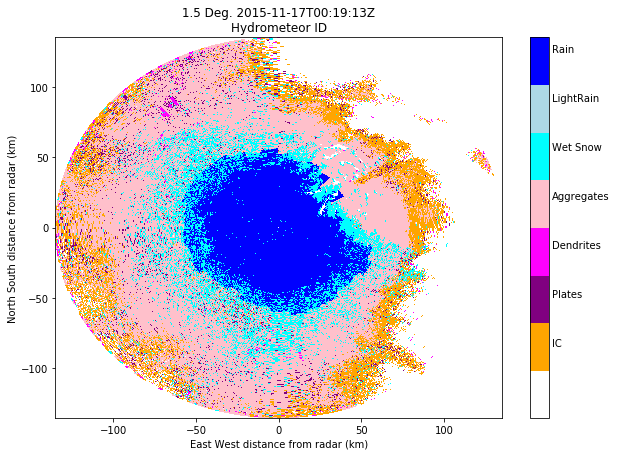

In [16]:
###Let's see what we got.
fig, ax = plt.subplots(1,1,figsize=(10,7))
display = pyart.graph.RadarDisplay(radar)
display.plot('HCA',sweep=1,vmin=0,vmax=7,cmap=cmaphidwinter)
display.cbs[0] = adjust_fhc_colorbar_for_pyart(display.cbs[0],'winter')



In [17]:
## We will start by using the temperature beta funcitons, and the hybrid scoring method.

hid = csu_fhc.csu_fhc_summer(dz=dz, zdr=dr, rho=rh, kdp=kd, use_temp=True,T=radar_T, band=rband,
                                verbose=False,use_trap=False,method='hybrid')#,fdir ='/home/bdolan/python/CSU_RadarTools/csu_radartools/beta_function_parameters/')


###Now add this back to the radar object.

radar = add_field_to_radar_object(hid, radar,field_name='HID',dz_field='corrected_reflectivity')



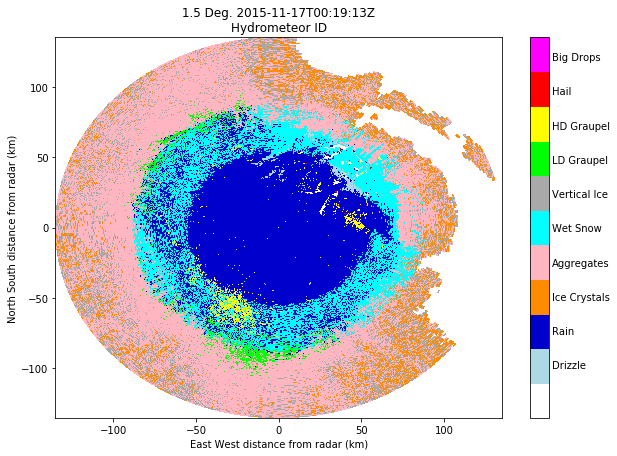

In [18]:
###Let's see what we got.
fig, ax = plt.subplots(1,1,figsize=(10,7))
display = pyart.graph.RadarDisplay(radar)
display.plot('HID',sweep=1,vmin=0,vmax=10,cmap=cmaphid)
display.cbs[0] = adjust_fhc_colorbar_for_pyart(display.cbs[0],'summer')

##You can see here that the wet snow is confined to concentric rings defined by the temperature range allowed by the HID,
##and found in the interpolated sounding. To the NE, this is significantly different than the solution above with the HCA.


In [19]:
##Now what if we use trapazoidal functions and the linear method?

hidT = csu_fhc.csu_fhc_summer(dz=dz, zdr=dr, rho=rh, kdp=kd, use_temp=True,T=radar_T, band=rband,
                                verbose=False,use_trap=True,method='linear')#,fdir ='/home/bdolan/python/CSU_RadarTools/csu_radartools/beta_function_parameters/')


###Now add this back to the radar object.

radar = add_field_to_radar_object(hidT, radar,field_name='HIDT',dz_field='corrected_reflectivity')




0.5


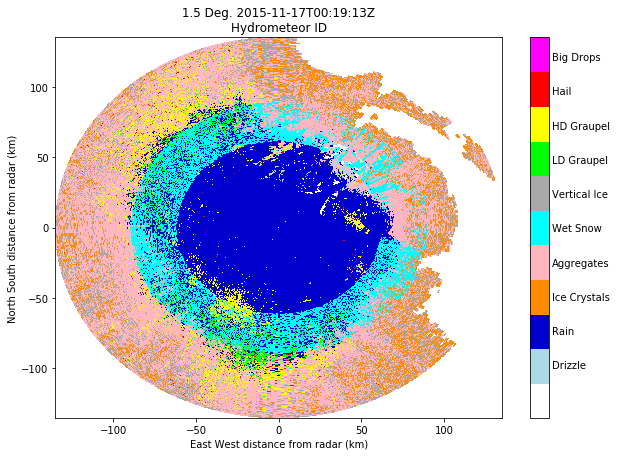

In [20]:
###Let's see what we got.
fig, ax = plt.subplots(1,1,figsize=(10,7))
display = pyart.graph.RadarDisplay(radar)
display.plot('HIDT',sweep=1,vmin=0,vmax=10,cmap=cmaphid)
display.cbs[0] = adjust_fhc_colorbar_for_pyart(display.cbs[0],'summer')

## again confined to the concentric temperature rings, but now seeing more differentiation in the ice.


In [22]:
###A final note. While it might seem "easy" to use the melting layer identification algorithm for temperature in the
##Summer HID to solve some of these problems, the backend architecture of the two fuzzy logic algorithms is currently
##incompatable. The winter HCA runs seperate algorithms above and below a freezing level, while the summer HCA takes a 
##temperature profile.

##This is also the case for adding graupel to the HCA.